# Classification of written and spoken digits

## Imports

In [1]:
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split  
from scipy.stats import kurtosis

## Loading Data

In [2]:
written_train = numpy.load("C:/Users/voice/written-spoken-cnn/written_train(1).npy", allow_pickle=True)
spoken_train = numpy.load("C:/Users/voice/written-spoken-cnn/spoken_train(1).npy", allow_pickle=True)
match_train = numpy.load("C:/Users/voice/written-spoken-cnn/match_train(1).npy", allow_pickle=True)

print("written train shape:", written_train.shape)
print("spoken train shape:", spoken_train.shape)
print("match train shape:", match_train.shape)

written train shape: (45000, 784)
spoken train shape: (45000,)
match train shape: (45000,)


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
largest_shape = 0
for i in spoken_train:
    shape = i.shape[0]
    if shape > largest_shape:
        largest_shape = shape

print(largest_shape)

93


In [5]:
new_spoken_train = []
for example in spoken_train:
    difference = largest_shape-example.shape[0]
    zero_pad = numpy.pad(example,((0,difference),(0,0)), mode='constant')
    new_spoken_train.append(zero_pad)

new_spoken_train = numpy.array(new_spoken_train)
new_spoken_train.shape

(45000, 93, 13)

In [6]:
print(93*13)

1209


In [7]:
spoken_train = new_spoken_train
spoken_train = numpy.reshape(spoken_train,(45000,1209))

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(spoken_train)
spoken_train = scaler.transform(spoken_train)

# Normalize pixel values to be between 0 and 1
- divide written_train by 255

In [9]:
X_written = written_train/255
X_spoken = spoken_train
y = match_train

## Label distribution

In [10]:
total = len(y)
positives = sum(y)
negatives = total - positives

print("number of total rows: {}".format(total))
print("number of positives: {} ({}%)".format(positives, round((positives/total)*100,2)))
print("number of negatives: {} ({}%)".format(negatives, round((negatives/total)*100,2)))

number of total rows: 45000
number of positives: 4539 (10.09%)
number of negatives: 40461 (89.91%)


In [11]:
X_written = numpy.reshape(X_written,(45000,784))
X_spoken = numpy.reshape(X_spoken,(45000,1209))

In [12]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_written, y1 = oversampler.fit_resample(X_written, y)
X_spoken, y2 = oversampler.fit_resample(X_spoken, y)
print('Resampled dataset shape %s' % Counter(y2))

C:\Users\voice\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\voice\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\voice\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

Resampled dataset shape Counter({False: 40461, True: 40461})


In [13]:
print(X_written.shape)
print(X_spoken.shape)
print(y2.shape)

(80922, 784)
(80922, 1209)
(80922,)


# step 1: split data in training and validation:
- written train split: 80% train, 20% validation
<br>
- spoken train split: 80% train, 20% validation

Since the data is imbalanced, we use stratify to make sure the distribution of labels is the same in our train and validation datasets

In [14]:
X_written_train, X_written_test, X_spoken_train, X_spoken_test, y_train, y_valid = train_test_split(X_written, X_spoken, y2, test_size=0.20, stratify = y2)

In [15]:
X_written_test.shape

(16185, 784)

In [16]:
X_written_test = numpy.reshape(X_written_test,(X_written_test.shape[0],28,28))
X_written_train = numpy.reshape(X_written_train,(X_written_train.shape[0],28,28))
X_spoken_test = numpy.reshape(X_spoken_test,(X_spoken_test.shape[0],93,13))
X_spoken_train = numpy.reshape(X_spoken_train,(X_spoken_train.shape[0],93,13))

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
#create model
import keras
from keras.optimizers import Adam

input1 = keras.layers.Input(shape=(28,28))
x1 = keras.layers.Conv1D(64, 2, activation='relu')(input1)
x1 = keras.layers.MaxPooling1D(2)(x1)
x2 = keras.layers.Conv1D(32, 2, activation='relu')(x1)
#x2 = keras.layers.MaxPooling1D(2)(x2)
x3 = keras.layers.Flatten()(x2)
input2 = keras.layers.Input(shape=(93,13))
y1 = keras.layers.Conv1D(64, 2, activation='relu')(input2)
y1 = keras.layers.MaxPooling1D(2)(y1)
y2 = keras.layers.Conv1D(32, 2, activation='relu')(y1)
#y2 = keras.layers.MaxPooling1D(2)(y2)
y3 = keras.layers.Flatten()(y2)
# Equivalent to subtracted = keras.layers.subtract([x1, x2])
concatenate = keras.layers.Concatenate()([x3, y3])
Dense_1 = Dense(100, activation='relu')(concatenate)
Dense_2 = Dense(100, activation='relu')(Dense_1)
out = keras.layers.Dense(1, activation = "sigmoid")(Dense_2)
model = keras.models.Model(inputs=[input1, input2], outputs=out)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001), metrics=['accuracy'])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 93, 13)       0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 27, 64)       3648        input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 92, 64)       1728        input_6[0][0]                    
____________________________________________________________________________________________

In [27]:
history = model.fit([X_written_train, X_spoken_train], y_train,
                    epochs=100, validation_split=0.1, batch_size=32)

Train on 58263 samples, validate on 6474 samples
Epoch 1/100
58263/58263 [==============================] - 25s 426us/step - loss: 0.3079 - acc: 0.8518 - val_loss: 0.1330 - val_acc: 0.95213095 - acc: 0.850 - ETA: 0s - loss: 0.3091 - acc: 0.8
Epoch 2/100
58263/58263 [==============================] - 23s 398us/step - loss: 0.0807 - acc: 0.9719 - val_loss: 0.0717 - val_acc: 0.9741
Epoch 3/100
58263/58263 [==============================] - 29s 501us/step - loss: 0.0422 - acc: 0.9865 - val_loss: 0.0507 - val_acc: 0.9852
Epoch 4/100
58263/58263 [==============================] - 23s 401us/step - loss: 0.0325 - acc: 0.9897 - val_loss: 0.0482 - val_acc: 0.9827
Epoch 5/100
58263/58263 [==============================] - 23s 390us/step - loss: 0.0229 - acc: 0.9924 - val_loss: 0.0394 - val_acc: 0.9893
Epoch 6/100
58263/58263 [==============================] - 24s 409us/step - loss: 0.0182 - acc: 0.9945 - val_loss: 0.0285 - val_acc: 0.9921- ETA: 0s - loss: 0.0184 
Epoch 7/100
58263/58263 [========

58263/58263 [==============================] - 25s 437us/step - loss: 5.5340e-04 - acc: 1.0000 - val_loss: 0.0291 - val_acc: 0.9963
Epoch 57/100
58263/58263 [==============================] - 26s 443us/step - loss: 5.5340e-04 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9963: 4s -  - ETA: 2s - loss: 6.2504e-04 - acc: - ETA: 2s - loss - ETA: 1s - loss: 5.7674
Epoch 58/100
58263/58263 [==============================] - 25s 425us/step - loss: 5.5340e-04 - acc: 1.0000 - val_loss: 0.0293 - val_acc: 0.9964
Epoch 59/100
58263/58263 [==============================] - 14s 242us/step - loss: 5.5340e-04 - acc: 1.0000 - val_loss: 0.0296 - val_acc: 0.9964
Epoch 60/100
58263/58263 [==============================] - 9s 160us/step - loss: 5.5340e-04 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9964
Epoch 61/100
58263/58263 [==============================] - 9s 161us/step - loss: 5.5340e-04 - acc: 1.0000 - val_loss: 0.0293 - val_acc: 0.9964
Epoch 62/100
58263/58263 [==============================] - 

# plot loss and accuracy

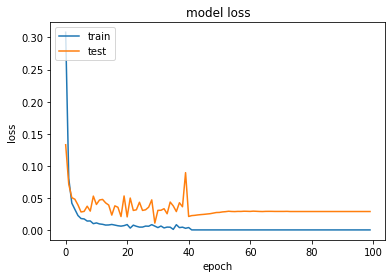

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

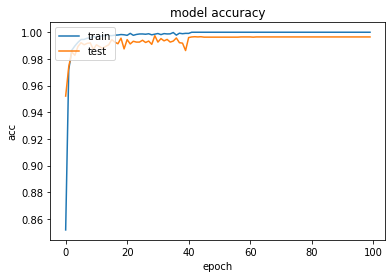

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# classification_report, confusion_matrix, accuracy_score

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
conf_matrix = confusion_matrix(y_valid, numpy.round(model.predict([X_written_test, X_spoken_test])))
class_report = classification_report(y_valid, numpy.round(model.predict([X_written_test, X_spoken_test])))
acc_report = accuracy_score(y_valid, numpy.round(model.predict([X_written_test, X_spoken_test])))

In [31]:
print(class_report)
print(conf_matrix)
print()
print(acc_report)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      8092
        True       1.00      1.00      1.00      8093

    accuracy                           1.00     16185
   macro avg       1.00      1.00      1.00     16185
weighted avg       1.00      1.00      1.00     16185

[[8052   40]
 [   4 8089]]

0.9972814334260117


In [34]:
train_acc = accuracy_score(y_train, numpy.round(model.predict([X_written_train, X_spoken_train])))
test_acc = acc_report

In [35]:
print("train accuracy: {}".format(train_acc))
print("test accuracy: {}".format(test_acc))

train accuracy: 0.9996138220801087
test accuracy: 0.9972814334260117
